In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = 'Surface_Analysis_Results.xlsx'

# Read the Excel file
df_firstSurvey = pd.read_excel(file_path, sheet_name='Initial Scan')
df_firstMultiplex = pd.read_excel(file_path, sheet_name='MultiplexInitialScan')
df_firstPointSputtering = pd.read_excel(file_path, sheet_name='Point1_Depth')
df_secondPointSputtering = pd.read_excel(file_path, sheet_name='Point2_Depth')
df_thirdPointSputtering = pd.read_excel(file_path, sheet_name='Point3_Depth')
df_finalScan = pd.read_excel(file_path, sheet_name='Final_Survey')

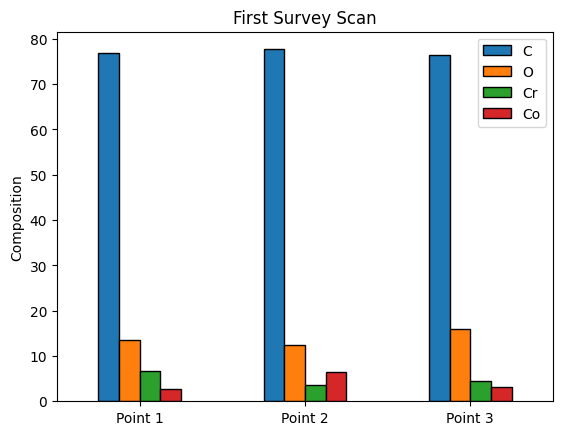

In [2]:
#%% FIRST SURVEY
# Plotting the bar graph with specified modifications
ax = df_firstSurvey.plot(kind='bar', edgecolor='black')
ax.set_ylabel("Composition")
ax.set_xticklabels(["Point 1", "Point 2", "Point 3"], rotation=0)  # Horizontal x-axis labels
ax.set_title("First Survey Scan")
# plt.savefig('/Users/doruksinayuc/OneDrive - metu.edu.tr/EPFL/Classes/Surface Analysis/Presentation/Figures/FirstScan.png', dpi=1200)  # Saves the figure as a PNG file with a DPI of 300
plt.show()

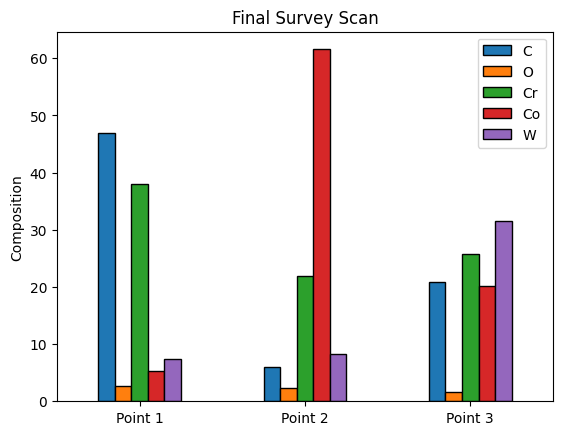

In [3]:
#%% FINAL SURVEY
# Plotting the bar graph with specified modifications
ax = df_finalScan.plot(kind='bar', edgecolor='black')
ax.set_ylabel("Composition")
ax.set_xticklabels(["Point 1", "Point 2", "Point 3"], rotation=0)  # Horizontal x-axis labels
ax.set_title("Final Survey Scan")
# plt.savefig('/Users/doruksinayuc/OneDrive - metu.edu.tr/EPFL/Classes/Surface Analysis/Presentation/Figures/FinalScan.png', dpi=1200)  # Saves the figure as a PNG file with a DPI of 300
plt.show()

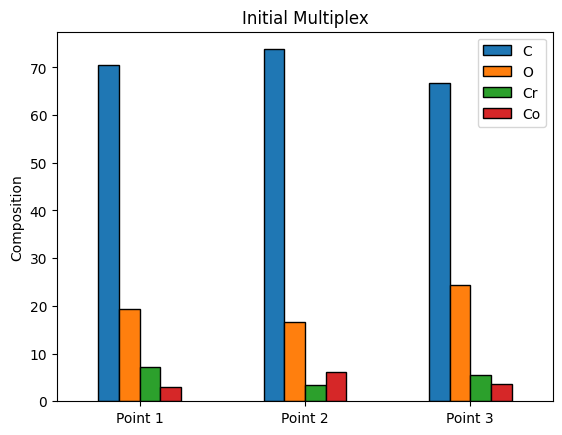

In [4]:
#%% FIRST MULTIPLEX
# Plotting the bar graph with specified modifications
ax = df_firstMultiplex.plot(kind='bar', edgecolor='black')
ax.set_ylabel("Composition")
ax.set_xticklabels(["Point 1", "Point 2", "Point 3"], rotation=0)  # Horizontal x-axis labels
ax.set_title("Initial Multiplex")
# plt.savefig('/Users/doruksinayuc/OneDrive - metu.edu.tr/EPFL/Classes/Surface Analysis/Presentation/Figures/FirstMultiplex.png', dpi=1200)  # Saves the figure as a PNG file with a DPI of 300
plt.show()

In [5]:
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

# Define the Gaussian function
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

In [6]:
def walker(y,max_peak_index,fall):
    amp = y[max_peak_index]
    pos_index = max_peak_index
    while y[pos_index] > amp*fall:
        pos_index = pos_index+1
    return pos_index   

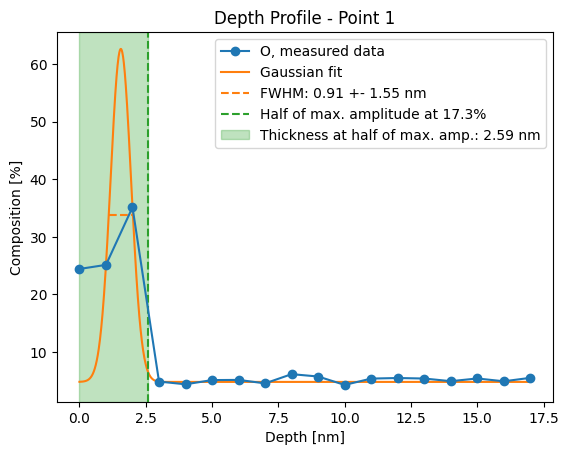

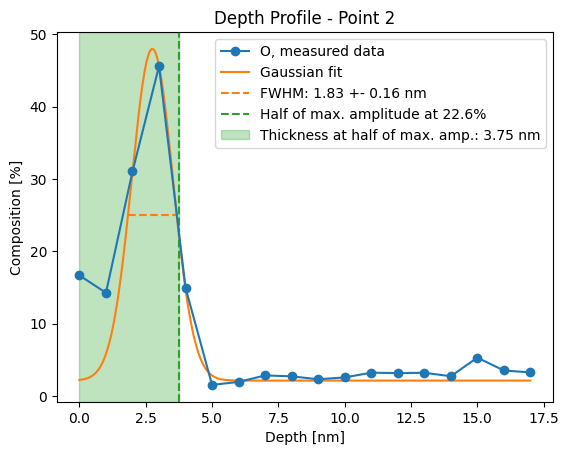

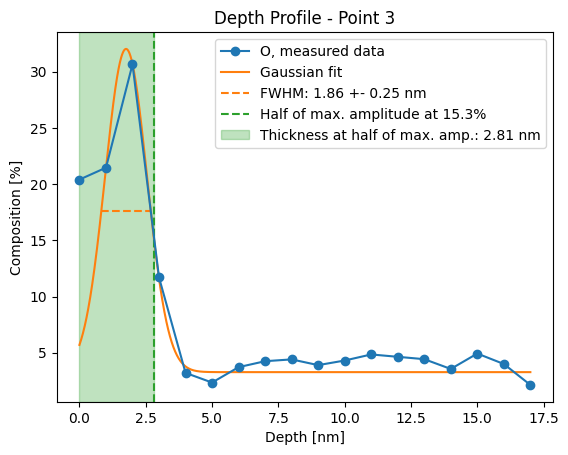

In [13]:
for i,df in enumerate([df_firstPointSputtering,df_secondPointSputtering,df_thirdPointSputtering]):

    # Creating an array for the x-axis (0.5 nm steps)
    nm_steps = np.array([i * 1 for i in range(df.shape[0])])

    # Creating an array for the x-axis with 0.1 nm steps for interpolation
    nm_steps_interp = np.arange(0, df.shape[0], 0.01)

    # Plotting the line graph 
    plt.figure()
    for column in df.columns:
        if column == "O":
            plt.plot(nm_steps, df[column], label=f'{column}, measured data', zorder=100, marker="o")
        if column == "O":
            peaks, properties = find_peaks(df[column],  prominence=1,)

            # Fit a Gaussian to the highest peak
            peak_heights = df[column][peaks]
            max_peak_index = peak_heights.idxmax()

            # Select data to the right of the peak
            x_data_to_fit = nm_steps[max_peak_index-1:max_peak_index+6]
            y_data_to_fit = df[column][max_peak_index-1:max_peak_index+6]

            popt, pcov = curve_fit(gauss, x_data_to_fit, y_data_to_fit, p0=[min(y_data_to_fit), max(peak_heights), nm_steps[max_peak_index], 1])
            perr = np.sqrt(np.diag(pcov))

            # Increase resolution by creating more points for x_data
            x_data_high_res = np.linspace(nm_steps.min(), nm_steps.max(), len(nm_steps) * 100)

            # Plot the fitted Gaussian with higher resolution
            plt.plot(x_data_high_res, gauss(x_data_high_res, *popt), label=f'Gaussian fit')

            fwhm = abs(2*np.sqrt(2*np.log(2))*popt[3])
            fwhm_err = 2*np.sqrt(2*np.log(2))*3*perr[3]

            # Calculate the positions of the FWHM
            fwhm_start = popt[2] - fwhm/2
            fwhm_end = popt[2] + fwhm/2

            hm = (gauss(popt[2], *popt)-popt[0])/2 +popt[0]


            # Plot the FWHM on the graph
            # plt.axvline(fwhm_start, color='r', linestyle='--', label='FWHM start')
            # plt.axvline(fwhm_end, color='r', linestyle='--', label='FWHM end')
            plt.hlines(hm, fwhm_start, fwhm_end, linestyle='--', label='FWHM: {:.2f} +- {:.2f} nm'.format(fwhm, fwhm_err), color='tab:orange')

            # plt.plot(nm_steps[peaks], df[column][peaks], "x", label="nm_steps")


            # Interpolate the data
            interp_data = np.interp(nm_steps_interp, nm_steps, df[column])

            # Plot the interpolated data
            # plt.plot(nm_steps_interp, interp_data, label=f'{column} Interpolated')


            hmfall = walker(interp_data, np.argmax(interp_data), 0.5)
            plt.axvline(nm_steps_interp[hmfall], color='tab:green', linestyle='--', label=f'Half of max. amplitude at {interp_data[hmfall]:.3}%')

            plt.axvspan(0,nm_steps_interp[hmfall], alpha=0.3, color='tab:green', label=f'Thickness at half of max. amp.: {nm_steps_interp[hmfall]} nm')



    plt.xlabel('Depth [nm]')
    plt.ylabel('Composition [%]')
    plt.title(f'Depth Profile - Point {i+1}')
    plt.legend(loc='upper right')
    plt.savefig(f'sputter_point{i+1}.png', dpi=1200)  # Saves the figure as a PNG file with a DPI of 300
    plt.show()

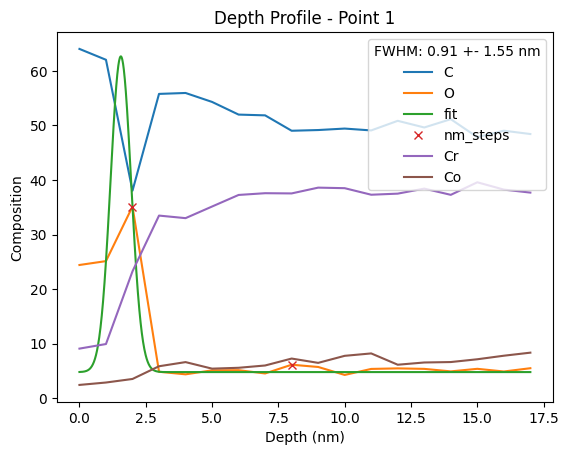

In [8]:
#%% POINT 1 SPUTTERING


# #Assuming sputter rate 1nm/min and take value every 30 seconds
# range_with_step = np.arange(0, 9.5, 0.5)

# Creating an array for the x-axis (0.5 nm steps)
nm_steps = np.array([i * 1 for i in range(df_firstPointSputtering.shape[0])])

# Plotting the line graph 
plt.figure()
for column in df_firstPointSputtering.columns:
    plt.plot(nm_steps, df_firstPointSputtering[column], label=column)
    if column == "O":
        peaks, properties = find_peaks(df_firstPointSputtering[column],  prominence=1,)
        
        # Fit a Gaussian to the highest peak
        peak_heights = df_firstPointSputtering[column][peaks]
        max_peak_index = peak_heights.idxmax()
        
        # Select data to the right of the peak
        x_data_to_fit = nm_steps[max_peak_index-1:max_peak_index+6]
        y_data_to_fit = df_firstPointSputtering[column][max_peak_index-1:max_peak_index+6]
    
        popt, pcov = curve_fit(gauss, x_data_to_fit, y_data_to_fit, p0=[min(y_data_to_fit), max(peak_heights), nm_steps[max_peak_index], 1])
        perr = np.sqrt(np.diag(pcov))
        
        # Increase resolution by creating more points for x_data
        x_data_high_res = np.linspace(nm_steps.min(), nm_steps.max(), len(nm_steps) * 100)
        
        # Plot the fitted Gaussian with higher resolution
        plt.plot(x_data_high_res, gauss(x_data_high_res, *popt), label=f'fit')
        
        fwhm = abs(2*np.sqrt(2*np.log(2))*popt[3])
        fwhm_err = 2*np.sqrt(2*np.log(2))*3*perr[3]
        
        plt.plot(nm_steps[peaks], df_firstPointSputtering[column][peaks], "x", label="nm_steps")

plt.xlabel('Depth (nm)')
plt.ylabel('Composition')
plt.title('Depth Profile - Point 1')
plt.legend(loc='upper right',title='FWHM: {:.2f} +- {:.2f} nm'.format(fwhm, fwhm_err))
# plt.savefig('/Users/doruksinayuc/OneDrive - metu.edu.tr/EPFL/Classes/Surface Analysis/Presentation/Figures/FirstPointSputter.png', dpi=1200)  # Saves the figure as a PNG file with a DPI of 300
plt.show()

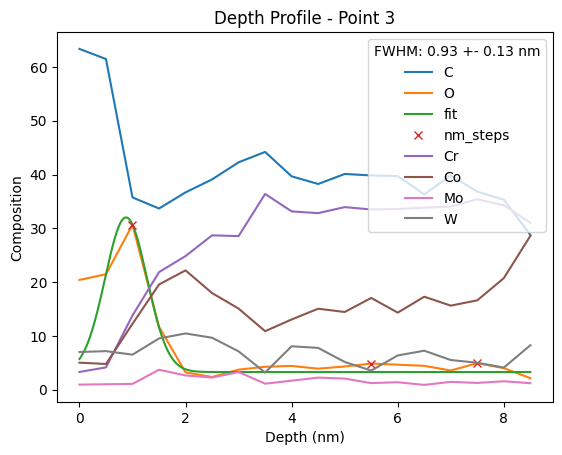

In [9]:
#%% POINT 3 SPUTTERING
# Creating an array for the x-axis (0.5 nm steps)
nm_steps = np.array([i * 0.5 for i in range(df_thirdPointSputtering.shape[0])])

# Plotting the line graph 
plt.figure()
for column in df_thirdPointSputtering.columns:
    plt.plot(nm_steps, df_thirdPointSputtering[column], label=column)
    
    if column == "O":
        peaks, properties = find_peaks(df_thirdPointSputtering[column],  prominence=1,)
        
        # Fit a Gaussian to the highest peak
        peak_heights = df_thirdPointSputtering[column][peaks]
        max_peak_index = peak_heights.idxmax()
        
        # Select data to the right of the peak
        x_data_to_fit = nm_steps[max_peak_index-1:max_peak_index+6]
        y_data_to_fit = df_thirdPointSputtering[column][max_peak_index-1:max_peak_index+6]
    
        popt, pcov = curve_fit(gauss, x_data_to_fit, y_data_to_fit, p0=[min(y_data_to_fit), max(peak_heights), nm_steps[max_peak_index], 0.1])
        perr = np.sqrt(np.diag(pcov))
        
        # Increase resolution by creating more points for x_data
        x_data_high_res = np.linspace(nm_steps.min(), nm_steps.max(), len(nm_steps) * 100)
        
        # Plot the fitted Gaussian with higher resolution
        plt.plot(x_data_high_res, gauss(x_data_high_res, *popt), label=f'fit')
        
        fwhm = abs(2*np.sqrt(2*np.log(2))*popt[3])
        fwhm_err = 2*np.sqrt(2*np.log(2))*3*perr[3]
        
        plt.plot(nm_steps[peaks], df_thirdPointSputtering[column][peaks], "x", label="nm_steps")

plt.xlabel('Depth (nm)')
plt.ylabel('Composition')
plt.title('Depth Profile - Point 3')
plt.legend(loc='upper right',title='FWHM: {:.2f} +- {:.2f} nm'.format(fwhm, fwhm_err))
plt.show()
